In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow import keras
from tensorflow.keras.layers import *
from prepare_data import *
from datetime import datetime
from tensorflow.keras.applications.inception_v3 import preprocess_input
import albumentations as A

In [2]:
dataset = Dataset.carabid
_, val_dataset = prep_data_single(dataset, 1)


extractor_model_path = "models/carabid/CARABID-EXTRACTOR/extractor/savefile.hdf5"
extractor_model = keras.models.load_model(extractor_model_path)

augs = {"no augs": None,
        "horizontal flip": A.Compose([A.HorizontalFlip(p=1.0)]),
        "vertical flip": A.Compose([A.VerticalFlip(p=1.0)]),
        "rotate": A.Compose([A.Rotate(p=1.0)]),
        "brightness/contrast": A.Compose([A.RandomBrightnessContrast(p=1.0)]),
        "gamma": A.Compose([A.RandomGamma(p=1.0)]),
        "grey": A.Compose([A.ToGray(p=1.0)]),
        "blur": A.Compose([A.Blur(p=1.0)])}

Found 63364 files belonging to 291 classes.
Using 53860 files for training.
Found 63364 files belonging to 291 classes.
Using 9504 files for validation.


In [3]:
aug_results = {}
for name, aug in augs.items():
    _, extractor_val = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=aug)
    aug_results[name] = extractor_model.evaluate(extractor_val)

print(aug_results)

9504/9504 [==============================] - 156s 16ms/step - loss: 5.4790 - accuracy: 0.3787
{'no augs': [0.41842904686927795, 0.8894149661064148], 'horizontal flip': [0.41799378395080566, 0.8902567625045776], 'vertical flip': [0.4215128421783447, 0.8912037014961243], 'rotate': [0.4481838345527649, 0.8833122849464417], 'brightness/contrast': [0.9452727437019348, 0.7766203880310059], 'gamma': [0.4777602255344391, 0.8717381954193115], 'grey': [7.036161422729492, 0.11416245996952057], 'blur': [5.479002952575684, 0.3786826729774475]}


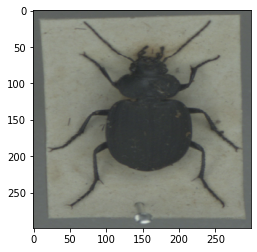

In [12]:
_, extractor_val = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=augs['brightness/contrast'])
import matplotlib.pyplot as plt
x, y = extractor_val.__getitem__(0)
plt.imshow(x[0])

In [ ]:
dataset = Dataset.carabid
current_time = datetime.now().strftime("%d%m%Y-%H%M%S")
extractor_train, extractor_val = prep_data_single(dataset, 8)

In [ ]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.RandomBrightnessContrast(p=1.0),
    A.RandomGamma(p=0.5),
    A.ToGray(p=0.3),
    A.Blur(p=0.3),
])

train_gen, val_gen = prep_data_augmented(dataset, extractor_train, extractor_val, 8, 3, augment=augment)

x, _ = train_gen.__getitem__(0)

import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,3)
axarr[0].imshow(x[0][0])
axarr[1].imshow(x[0][1])
axarr[2].imshow(x[0][2])
# axarr[3].imshow(x[0][3])

In [ ]:
inception = InceptionV3(classifier_activation=None)
inception.trainable = True

inputs = keras.Input(shape=(299, 299, 3))
flip_aug = experimental.preprocessing.RandomFlip()(inputs)
rotate_aug = experimental.preprocessing.RandomRotation(0.2)(flip_aug)
preprocessing = preprocess_input(rotate_aug)
extractor = inception(preprocessing, training=False)
inception_model = keras.Model(inputs=inputs, outputs=extractor)
print(inception_model.summary())

In [ ]:
extractor_logdir = "logs/unfiltered/{0}_{1}/extractor".format(str(dataset), current_time)
extractor_tensorboard_callback = keras.callbacks.TensorBoard(log_dir=extractor_logdir)

extractor_model_path = "models/unfiltered/{0}_{1}/extractor/savefile.hdf5".format(str(dataset), current_time)
extractor_model_save_callback = keras.callbacks.ModelCheckpoint(filepath=extractor_model_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [ ]:
feature_extractor = keras.Sequential([inception_model, keras.layers.Dense(num_classes(dataset), activation='softmax')])
feature_extractor.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(feature_extractor.summary())

In [ ]:
feature_extractor.fit(extractor_train, validation_data=extractor_val, callbacks=[extractor_tensorboard_callback, extractor_model_save_callback], epochs=15)

In [ ]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.RandomBrightnessContrast(p=1.0),
    A.RandomGamma(p=0.5),
    A.ToGray(p=0.3),
    A.Blur(p=0.3),
])

train_gen, val_gen = prep_data_augmented(dataset, extractor_train, extractor_val, 8, 5, augment=augment)
del extractor_train
del extractor_val

In [ ]:
extractor_model_path = "models/ninety/NINETY-EXTRACTOR/extractor/savefile.hdf5"

feature_extractor = keras.models.load_model(extractor_model_path)
inception_model = feature_extractor.layers[0].layers[-1]
inception_model.trainable = False

classifier_model = keras.Sequential([
    InputLayer(input_shape=(None, 299, 299, 3)),
    TimeDistributed(inception_model),
    Bidirectional(LSTM(1000)),
    Dropout(0.5),
    Dense(1000, activation='relu'),
    Dense(train_gen.num_classes(), activation='softmax')
])

classifier_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(classifier_model.summary())

In [ ]:
logdir = "logs/unfiltered/{0}_{1}/classifier".format(str(dataset), current_time)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model_path = "models/unfiltered/{0}_{1}/classifier/savefile.hdf5".format(str(dataset), current_time)
model_save_callback = keras.callbacks.ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [ ]:
class ShuffleCallback(keras.callbacks.Callback):
    def __init__(self, generator):
        self._generator = generator
        
    def on_epoch_end(self, epoch, logs=None):
        self._generator.shuffle()
    
train_shuffle_callback = ShuffleCallback(train_gen)
val_shuffle_callback = ShuffleCallback(val_gen)

In [ ]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
classifier_model.fit(train_gen, validation_data=val_gen, callbacks=[tensorboard_callback, model_save_callback, train_shuffle_callback, val_shuffle_callback], epochs=20)

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf

class Classifier:
    def __init__(self, model_path, category_dict):
        self.model = keras.models.load_model(model_path)
        self.category_dict = category_dict
        self.augment = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(p=0.5),
            A.RandomBrightnessContrast(p=1.0),
            A.RandomGamma(p=0.5),
            A.ToGray(p=0.3),
            A.Blur(p=0.3),
        ])

    def classify(self, img_path, num_augments=6):
        input_array = self._make_augment_array(np.asarray(img_to_array(load_img(img_path, target_size=(299, 299))), dtype='uint8'), num_augments)
        prediction = self.model(input_array)
        print(tf.math.argmax(prediction, axis=1)[0].numpy())

    def _make_augment_array(self, img, num_augments):
        result = [preprocess_input(img)]
        for i in range(num_augments - 1):
            result.append(preprocess_input(self.augment(image=img)["image"]))
        return np.asarray([result])

In [ ]:
model = Classifier("models/carabid/CARABID_AUG-6_CLASSIFIER/classifier/savefile.hdf5", {})

img_path = "datasets/carabid/9581584/d135s0001.jpg"

model.classify(img_path)